---

**Matteo Serafino**   
**Date:** October 9, 2024  
**Email:** [matteo.serafino191@gmail.com](mailto:matteo.serafino191@gmail.com)

---
This notebook contains the analysis for: "Cognitive distortions in political polarization" by Andy Edinger, Johan Bollena, Hernán A. Makse, and Matteo Serafino.
---


In [1]:
import pandas as pd
import json
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

import scipy.stats as stats
from scipy.stats import ttest_ind,ttest_rel
from scipy.signal import find_peaks

from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Import necessary libraries
import pandas as pd

# Load the user distortion data
users_distortion = pd.read_csv('user_cds.csv')
# Ensure that the 'user_id' column is of string type
users_distortion['user_id'] = users_distortion['user_id'].astype(str)

# Load the 2016 ideology estimates
users_ideology_2016 = pd.read_csv('ideology_estimates_2016_paper.csv')
# Ensure that the 'account_id' column is of string type
users_ideology_2016['account_id'] = users_ideology_2016['account_id'].astype(str)

# Load the 2020 ideology estimates
users_ideology_2020 = pd.read_csv('ideology_estimates_2020_paper.csv')
# Ensure that the 'account_id' column is of string type
users_ideology_2020['account_id'] = users_ideology_2020['account_id'].astype(str)

# Identify overlapping user IDs across all three datasets
users_overlaps = (set(users_ideology_2016['account_id'].to_list()) & 
                  set(users_ideology_2020['account_id'].to_list()) & 
                  set(users_distortion['user_id']))

# Print the number of overlapping users
print(f"Number of overlapping users: {len(users_overlaps)}")

# Filter the DataFrames to include only the overlapping users
users_ideology_2016_o = users_ideology_2016[users_ideology_2016.account_id.isin(users_overlaps)]
users_ideology_2020_o = users_ideology_2020[users_ideology_2020.account_id.isin(users_overlaps)]
users_distortion_o = users_distortion[users_distortion.user_id.isin(users_overlaps)].copy()

# Rename 'user_id' to 'account_id' in users_distortion_o to match the other DataFrames
users_distortion_o.rename(columns={'user_id': 'account_id'}, inplace=True)

# Merge filtered 2016 ideology estimates with the filtered distortion data
temp_2016 = pd.merge(users_ideology_2016_o, users_distortion_o, on='account_id', how='inner')

# Merge filtered 2020 ideology estimates with the filtered distortion data
temp_2020 = pd.merge(users_ideology_2020_o, users_distortion_o, on='account_id', how='inner')

# Select relevant columns from the temp_2020 DataFrame
temp_2020 = temp_2020[['account_id', 'est', '2016_prevalence', '2020_prevalence']]

# Merge temp_2020 with the filtered 2016 ideology estimates on 'account_id'
merged_df = temp_2020.merge(users_ideology_2016_o[['account_id', 'est']], on='account_id', how='left')

# Rename columns for clarity: 'est_x' to 'est_2020' and 'est_y' to 'est_2016'
merged_df.rename(columns={'est_x': 'est_2020', 'est_y': 'est_2016'}, inplace=True)

Number of overlapping users: 53493


# Section: CDS prevalence by year.

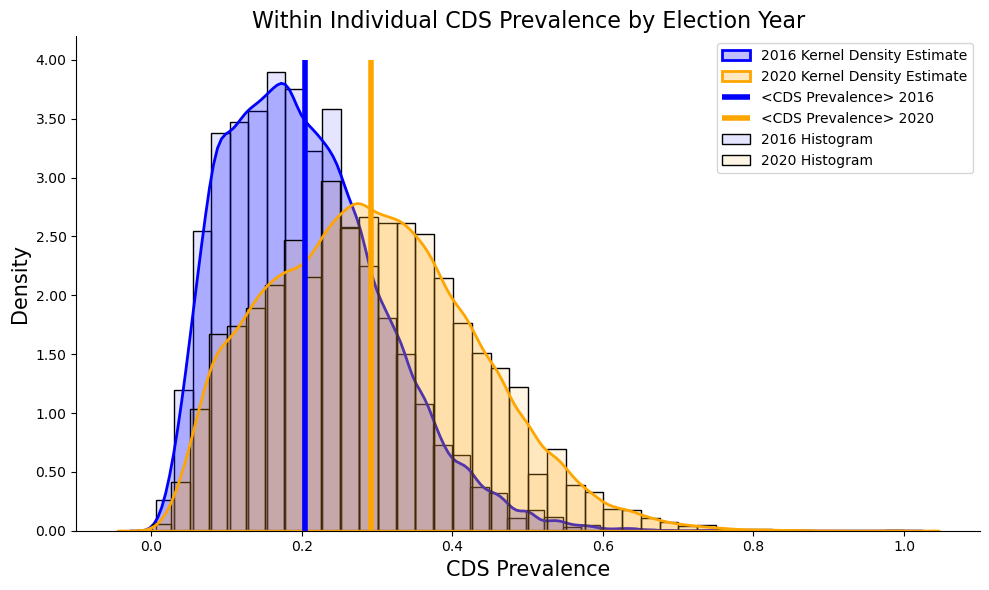

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# Calculate the mean prevalence for 2016 and 2020
mean_2016 = temp_2016['2016_prevalence'].mean()
mean_2020 = temp_2020['2020_prevalence'].mean()

# Set up the figure size for the plot
plt.figure(figsize=(10, 6))

# Plot the normalized histogram for 2016 prevalence
sns.histplot(temp_2020['2016_prevalence'], bins=40, kde=False, stat='density', color='blue', alpha=0.1, label='2016 Histogram')

# Plot the KDE for 2016 prevalence
sns.kdeplot(data=temp_2020['2016_prevalence'], color='blue', fill=True, linewidth=2, label='2016 Kernel Density Estimate')

# Plot the normalized histogram for 2020 prevalence
sns.histplot(temp_2020['2020_prevalence'], bins=40, kde=False, stat='density', color='orange', alpha=0.1, label='2020 Histogram')

# Plot the KDE for 2020 prevalence
sns.kdeplot(data=temp_2020['2020_prevalence'], color='orange', fill=True, linewidth=2, label='2020 Kernel Density Estimate')

# Add vertical lines at the mean values for 2016 and 2020
plt.vlines(x=mean_2016, ymin=0, ymax=4, color='blue', linestyle='-', linewidth=4, label=f'<CDS Prevalence> 2016')
plt.vlines(x=mean_2020, ymin=0, ymax=4, color='orange', linestyle='-',linewidth=4,  label=f'<CDS Prevalence> 2020')

# Labeling the axes and the plot
plt.ylabel('Density', fontsize=15)
plt.xlabel('CDS Prevalence', fontsize=15)
plt.title('Within Individual CDS Prevalence by Election Year', fontsize=16)

# Hide the right and top spines of the plot
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Force y-axis to show numbers with 2 decimal places
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Adjust layout to prevent cutoff of labels
plt.tight_layout()
# Show the legend and the plot
plt.legend()

# Save the figure as a PDF file
plt.savefig('plots/Figure1.pdf')


plt.show()

In [4]:
print('The % increase in CDS prevalence from 2016 to 2020 is:', round((mean_2020-mean_2016)/mean_2016,2),'%')

The % increase in CDS prevalence from 2016 to 2020 is: 0.43 %


In [5]:
# Performing the paired sample t-test
ttest = stats.ttest_rel(temp_2020['2020_prevalence'],
                        temp_2020['2016_prevalence'], alternative='greater')

# Extract t-statistic and p-value
t_stat = ttest.statistic
p_value = ttest.pvalue

# Print results with more decimals for p-value
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value:.100f}")  # Print the p-value with up to 100 decimal places


t-statistic: 153.8962992814723
p-value: 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


# Section: CDS prevalence & latent ideology.

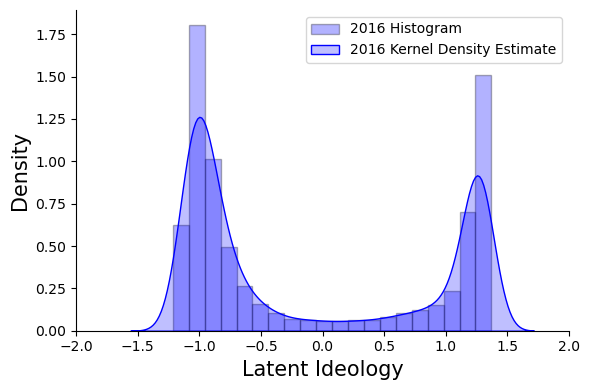

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# Set the number of bins for the histogram
num_bins = 20

# Create a figure for the plot
plt.figure(figsize=(6, 4))

# Plot the histogram for the 2016 latent ideology estimates
plt.hist(temp_2016['est'], bins=num_bins, edgecolor='black', density=True, alpha=0.3, color='blue', label='2016 Histogram')

# Overlay the KDE plot on top of the histogram
sns.kdeplot(data=temp_2016['est'], label='2016 Kernel Density Estimate', fill=True, color='blue')

# Label the axes
plt.ylabel('Density', fontsize=15)
plt.xlabel('Latent Ideology', fontsize=15)

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Set the x-axis limits
plt.xlim([-2, 2])

# Force y-axis to show numbers with 2 decimal places
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Adjust layout to prevent x-label cutoff
plt.tight_layout()

# Show the legend and the plot
plt.legend()
# Save the plot as a PDF file
plt.savefig('plots/2016_LI.pdf')

plt.show()


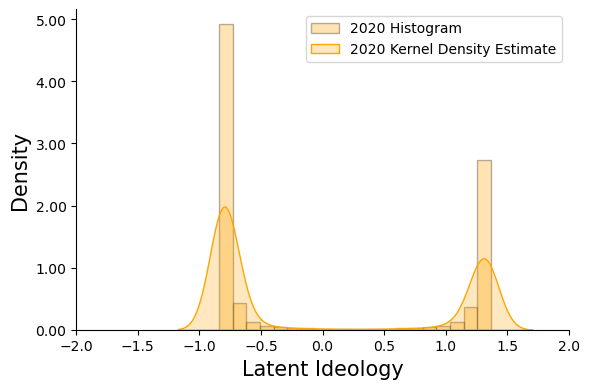

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# Set the number of bins for the histogram
num_bins = 20

# Create a figure for the plot
plt.figure(figsize=(6, 4))

# Plot the histogram for the 2016 latent ideology estimates
plt.hist(temp_2020['est'], bins=num_bins, edgecolor='black', density=True, alpha=0.3, color='orange', label='2020 Histogram')

# Overlay the KDE plot on top of the histogram
sns.kdeplot(data=temp_2020['est'], label='2020 Kernel Density Estimate', fill=True, color='orange')

# Label the axes
plt.ylabel('Density', fontsize=15)
plt.xlabel('Latent Ideology', fontsize=15)

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Set the x-axis limits
plt.xlim([-2, 2])

# Force y-axis to show numbers with 2 decimal places
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Adjust layout to prevent x-label cutoff
plt.tight_layout()

# Show the legend and the plot
plt.legend()
# Save the plot as a PDF file
plt.savefig('plots/2020_LI.pdf')

plt.show()


In [8]:
# Group by ideology for both 2016 and 2020 data
left_group_2016 = temp_2016[temp_2016.est < -0.5][['account_id', '2016_prevalence']]
right_group_2016 = temp_2016[temp_2016.est > 0.5][['account_id', '2016_prevalence']]
left_group_2020 = temp_2020[temp_2020.est < -0.5][['account_id', '2020_prevalence']]
right_group_2020 = temp_2020[temp_2020.est > 0.5][['account_id', '2020_prevalence']]

# Merge data to handle changes in group size - only keep common users in both years
merged_l = pd.merge(left_group_2016, left_group_2020, on='account_id', how='inner')
merged_r = pd.merge(right_group_2016, right_group_2020, on='account_id', how='inner')

# Compare the changes using paired t-tests
t_stat_left, p_value_left = ttest_rel(merged_l['2020_prevalence'], merged_l['2016_prevalence'], alternative='greater')
t_stat_right, p_value_right = ttest_rel(merged_r['2020_prevalence'], merged_r['2016_prevalence'], alternative='greater')

print('Number of users belonging to the left ideology:', len(merged_l))
# Output results for the left group
if p_value_left < 0.05:
    print(f'Paired t-test results for left 2016 vs left 2020: t-statistic = {t_stat_left}, p-value = {p_value_left}')
    print("The differences are statistically significant.\n")
else:
    print(f'Paired t-test results for left 2016 vs left 2020: t-statistic = {t_stat_left}, p-value = {p_value_left}')
    print("The differences are not statistically significant.\n")

print('Number of users belonging to the right ideology:', len(merged_r))
# Output results for the right group
if p_value_right < 0.05:
    print(f'Paired t-test results for right 2016 vs right 2020: t-statistic = {t_stat_right}, p-value = {p_value_right}')
    print("The differences are statistically significant.\n")
else:
    print(f'Paired t-test results for right 2016 vs right 2020: t-statistic = {t_stat_right}, p-value = {p_value_right}')
    print("The differences are not statistically significant.\n")


Number of users belonging to the left ideology: 29048
Paired t-test results for left 2016 vs left 2020: t-statistic = 113.40280322680447, p-value = 0.0
The differences are statistically significant.

Number of users belonging to the right ideology: 18631
Paired t-test results for right 2016 vs right 2020: t-statistic = 93.46524408985692, p-value = 0.0
The differences are statistically significant.



In [9]:
# Find users who switched from left to right and right to left
merged_lr = pd.merge(left_group_2016, right_group_2020, on='account_id', how='inner').dropna()
merged_rl = pd.merge(right_group_2016, left_group_2020, on='account_id', how='inner').dropna()

# Compare the changes using paired t-tests
t_stat_lr, p_value_lr = ttest_rel(merged_lr['2020_prevalence'], 
                                  merged_lr['2016_prevalence'], alternative='greater')

t_stat_rl, p_value_rl = ttest_rel(merged_rl['2020_prevalence'],
                                  merged_rl['2016_prevalence'], alternative='greater')

# Print the number of users who switched ideologies
print(f'Number of users who switched from left to right: {len(merged_lr)}')
# Output the results for left-to-right switchers
if p_value_lr < 0.05:
    print(f'Paired t-test results for left-to-right switchers (2016 vs 2020): t-statistic = {t_stat_lr}, p-value = {p_value_lr}')
    print("The differences are statistically significant.\n")
else:
    print(f'Paired t-test results for left-to-right switchers (2016 vs 2020): t-statistic = {t_stat_lr}, p-value = {p_value_lr}')
    print("The differences are not statistically significant.\n")

print(f'Number of users who switched from right to left: {len(merged_rl)}')
# Output the results for right-to-left switchers
if p_value_rl < 0.05:
    print(f'Paired t-test results for right-to-left switchers (2016 vs 2020): t-statistic = {t_stat_rl}, p-value = {p_value_rl}')
    print("The differences are statistically significant.\n")
else:
    print(f'Paired t-test results for right-to-left switchers (2016 vs 2020): t-statistic = {t_stat_rl}, p-value = {p_value_rl}')
    print("The differences are not statistically significant.\n")

Number of users who switched from left to right: 210
Paired t-test results for left-to-right switchers (2016 vs 2020): t-statistic = 7.826977465013509, p-value = 1.2293665211602544e-13
The differences are statistically significant.

Number of users who switched from right to left: 878
Paired t-test results for right-to-left switchers (2016 vs 2020): t-statistic = 22.935959775639464, p-value = 7.146837831264529e-92
The differences are statistically significant.



In [10]:
# Calculate the percentage change in CDS prevalence from 2016 to 2020 for left- and right-leaning users
diff_per_l = (merged_l['2020_prevalence'] - merged_l['2016_prevalence']) / merged_l['2016_prevalence']
diff_per_r = (merged_r['2020_prevalence'] - merged_r['2016_prevalence']) / merged_r['2016_prevalence']

# Print the mean relative change for both groups
print('Relative change in CDS prevalence for left-leaning:', round(diff_per_l.mean(),2),'%')
print('Relative change in CDS prevalence for right-leaning:', round(diff_per_r.mean(),2),'%')


# Perform an independent t-test to compare the percentage changes between the two groups
t_stat_lr, p_value_lr = ttest_ind(diff_per_r.dropna(), diff_per_l.dropna(), alternative='greater')

print('\n')
# Output the results
if p_value_lr < 0.05:
    print(f'Independent t-test results for diff_per_l vs diff_per_r: t-statistic = {t_stat_lr}, p-value = {p_value_lr}')
    print("The differences are statistically significant.\n")
else:
    print(f'Independent t-test results for diff_per_l vs diff_per_r: t-statistic = {t_stat_lr}, p-value = {p_value_lr}')
    print("The differences are not statistically significant.\n")



Relative change in CDS prevalence for left-leaning: 0.72 %
Relative change in CDS prevalence for right-leaning: 0.8 %


Independent t-test results for diff_per_l vs diff_per_r: t-statistic = 6.742167002856453, p-value = 7.89074342981971e-12
The differences are statistically significant.



# Section: CDS prevalence vs. latent ideology.

In [11]:
def find_peaks_above_threshold(data, threshold=0.1, plot=False):
    """
    Finds peaks in the KDE of the data that are above a certain threshold.

    Parameters:
    data (array-like): The input data for which KDE peaks are found.
    threshold (float): Minimum height for a peak to be considered.
    plot (bool): If True, plot the KDE. If False, only find peaks.

    Returns:
    array-like: X positions of the peaks above the threshold.
    """
    # Create KDE plot using Seaborn
    sns.kdeplot(data)

    # Get the data from the plot
    x_values = plt.gca().get_lines()[0].get_xdata()
    kde_values = plt.gca().get_lines()[0].get_ydata()

    if not plot: 
        # Close the plot
        plt.close()

    # Find peaks above the threshold in the KDE curve
    peaks, _ = find_peaks(kde_values, height=threshold)

    # Return x positions of the peaks
    return x_values[peaks]

def compute_value(est, pos_peak, neg_peak):
    """
    Compute the value based on the position of the estimate relative to peaks.

    Parameters:
    est (float): The estimate to evaluate.
    pos_peak (float): The position of the positive peak.
    neg_peak (float): The position of the negative peak.

    Returns:
    float: The computed value based on the estimate's proximity to the peaks.
    """
    if est > 0:
        return (pos_peak - est) / pos_peak
    else:
        return (est - neg_peak) / abs(neg_peak)

def find_peaks_above_threshold_plot(data, trh, threshold=0.1):
    """
    Identifies peaks above a threshold and plots them with vertical lines.

    Parameters:
    data (array-like): The input data for which KDE peaks are found.
    trh (float): Threshold for determining vertical line positions.
    threshold (float): Minimum height for a peak to be considered.

    Returns:
    tuple: Contains x_values, kde_values, x1, x2, and peak heights.
    """
    fig, ax = plt.subplots()
    
    # Create KDE plot using Seaborn
    sns.kdeplot(data, ax=ax)

    # Get the data from the plot
    x_values = plt.gca().get_lines()[0].get_xdata()
    kde_values = plt.gca().get_lines()[0].get_ydata()

    # Find peaks above the threshold in the KDE curve
    peaks, _ = find_peaks(kde_values, height=threshold)

    plt.vlines(x=x_values[peaks][0], ymin=0, ymax=kde_values[peaks][0], colors='green')
    plt.vlines(x=x_values[peaks][1], ymin=0, ymax=kde_values[peaks][1], colors='green')
    
    # Determine the x-values for the vertical lines
    x1 = x_values[peaks][0] + trh
    x2 = x_values[peaks][1] - trh
    
    plt.close()
    return x_values, kde_values, x1, x2, kde_values[peaks][0], kde_values[peaks][1]

def bootstrap_lowess(x, y, num_bootstrap=1000, frac=0.3):
    """
    Perform bootstrapping with LOWESS smoothing to estimate confidence intervals.

    Parameters:
    x (array-like): The independent variable.
    y (array-like): The dependent variable.
    num_bootstrap (int): Number of bootstrap samples to generate.
    frac (float): The fraction of data used for LOWESS smoothing.

    Returns:
    tuple: The smoothed values, lower and upper bounds of the confidence interval.
    """
    n = len(x)
    x_sorted_indices = np.argsort(x)
    x_sorted = x[x_sorted_indices]
    y_sorted = y[x_sorted_indices]
    
    y_pred = lowess(y_sorted, x_sorted, frac=frac, return_sorted=False)
    bootstrap_samples = np.zeros((num_bootstrap, n))

    for i in range(num_bootstrap):
        indices = np.random.choice(np.arange(n), n, replace=True)
        bootstrap_x = x_sorted[indices]
        bootstrap_y = y_sorted[indices]
        bootstrap_y_pred = lowess(bootstrap_y, bootstrap_x, frac=frac, return_sorted=False)
        bootstrap_samples[i, :] = np.interp(x_sorted, np.sort(bootstrap_x), bootstrap_y_pred[np.argsort(bootstrap_x)])

    lower_bound = np.percentile(bootstrap_samples, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_samples, 97.5, axis=0)
    return y_pred, lower_bound, upper_bound

def get_boostrap(df__):
    """
    Apply bootstrap_lowess and perform OLS regression on the smoothed data.

    Parameters:
    df__ (DataFrame): The DataFrame containing the 'metric' and 'delta_y' columns.

    Returns:
    tuple: Contains x, y_pred, lower_bound, upper_bound, y_pred_ols, slope, and p-value.
    """
    x = df__['metric'].values
    y = df__['delta_y'].values
    y_pred, lower_bound, upper_bound = bootstrap_lowess(x, y)

    # Perform OLS regression
    X = sm.add_constant(x)
    ols_model = sm.OLS(y_pred, X).fit()
    y_pred_ols = ols_model.predict(X)
    return x, y_pred, lower_bound, upper_bound, y_pred_ols, ols_model.params[1], ols_model.pvalues[1]

def compute_metric(x1, x2):
    """
    Compute the metric as the ratio difference.

    Parameters:
    x1 (float): The initial value.
    x2 (float): The subsequent value.

    Returns:
    float: The computed metric.
    """
    ratio = x2 / x1 
    metric = 1 - ratio
    return metric

def compute_metric2(x1, x2):
    """
    Compute the metric as the difference.

    Parameters:
    x1 (float): The initial value.
    x2 (float): The subsequent value.

    Returns:
    float: The computed metric.
    """
    return (x2 - x1)


In [12]:
# Select parameters
type_ = 'general' 
plot = False
distance_from_the_peak = np.arange(0,0.9,0.1)

if type_ == 'age':
    group_ = '55-64' #Other options: ['0-24', '25-34', '35-44', '45-54', '55-64', '65 and above']

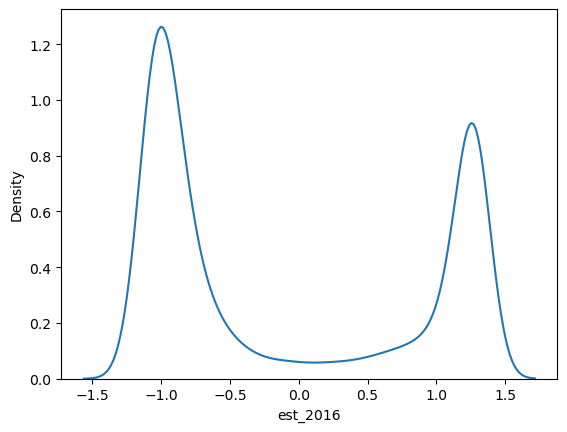

In [13]:
if type_ == 'general' or type_ == 'general_negative':
    merged_df_ = merged_df.copy()
    peaks_2020 = find_peaks_above_threshold(merged_df_['est_2020'])
    peaks_2016 = find_peaks_above_threshold(merged_df_['est_2016'],plot=True)
    
    positive_peak_value_2016 = peaks_2016[1]
    negative_peak_value_2016 = peaks_2016[0]
    
    positive_peak_value_2020 = peaks_2020[1]
    negative_peak_value_2020 = peaks_2020[0]
    
elif type_ == 'right':
    merged_df_ = merged_df[(merged_df['est_2016']>=0) & (merged_df['est_2020']>=0) ].copy()
    peaks_2020 = find_peaks_above_threshold(merged_df_['est_2020'])
    peaks_2016 = find_peaks_above_threshold(merged_df_['est_2016'],plot=True)
    
    positive_peak_value_2016 = peaks_2016[0]
    positive_peak_value_2020 = peaks_2020[0]
    
elif type_ == 'left':

    merged_df_ = merged_df[(merged_df['est_2016']<0) & (merged_df['est_2020']<0) ].copy()  
    peaks_2020 = find_peaks_above_threshold(merged_df_['est_2020'])
    peaks_2016 = find_peaks_above_threshold(merged_df_['est_2016'],plot=True)
    
    negative_peak_value_2016 = peaks_2016[0]
    negative_peak_value_2020 = peaks_2020[0]
    
elif type_ == 'male':
    # Load and preprocess the age and gender data
    age_gender = pd.read_csv('age_gender.csv')
    
    # Remove duplicate rows
    age_gender.drop_duplicates(inplace=True)
    
    # Ensure the 'account_id' columns are of string type for both DataFrames
    age_gender['account_id'] = age_gender['account_id'].astype(str)
    merged_df['account_id'] = merged_df['account_id'].astype(str)
    
    # Merge the DataFrames on 'account_id'
    merged_df_ = pd.merge(merged_df, age_gender, on='account_id').copy()
    merged_df_ = merged_df_[merged_df_.age=='Male']

    peaks_2020 = find_peaks_above_threshold(merged_df_['est_2020'])
    peaks_2016 = find_peaks_above_threshold(merged_df_['est_2016'],plot=True)

    positive_peak_value_2016 = peaks_2016[1]
    negative_peak_value_2016 = peaks_2016[0]
    
    positive_peak_value_2020 = peaks_2020[1]
    negative_peak_value_2020 = peaks_2020[0]
    
elif type_ == 'female':
    # Load and preprocess the age and gender data
    age_gender = pd.read_csv('age_gender.csv')
    
    # Remove duplicate rows
    age_gender.drop_duplicates(inplace=True)
    
    # Ensure the 'account_id' columns are of string type for both DataFrames
    age_gender['account_id'] = age_gender['account_id'].astype(str)
    merged_df['account_id'] = merged_df['account_id'].astype(str)
    
    # Merge the DataFrames on 'account_id'
    merged_df_ = pd.merge(merged_df, age_gender, on='account_id').copy()
    merged_df_ = merged_df_[merged_df_.age=='Female']

    peaks_2020 = find_peaks_above_threshold(merged_df_['est_2020'])
    peaks_2016 = find_peaks_above_threshold(merged_df_['est_2016'],plot=True)

    positive_peak_value_2016 = peaks_2016[1]
    negative_peak_value_2016 = peaks_2016[0]
    
    positive_peak_value_2020 = peaks_2020[1]
    negative_peak_value_2020 = peaks_2020[0]

elif type_ == 'age':
    # Load and preprocess the age and gender data
    age_gender = pd.read_csv('age_gender.csv')
    
    # Remove duplicate rows
    age_gender.drop_duplicates(inplace=True)
    
    # Ensure the 'account_id' columns are of string type for both DataFrames
    age_gender['account_id'] = age_gender['account_id'].astype(str)
    merged_df['account_id'] = merged_df['account_id'].astype(str)
    
    # Merge the DataFrames on 'account_id'
    merged_df_ = pd.merge(merged_df, age_gender, on='account_id').copy()
    
    # Define the age bins and labels
    bins = [0, 17, 24, 34, 44, 54, 64, float('inf')]
    labels = ['Below 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65 and above']
    
    # Create a new column 'age_group' with the categorized age groups
    merged_df_['age_group'] = pd.cut(merged_df_['gender'], bins=bins, labels=labels, right=True)
    if group_ == '0-24':
        merged_df_ = merged_df_[merged_df_['age_group'].isin([ 'Below 18','18-24'])].copy()
    elif group_ == '25-34':
        merged_df_ = merged_df_[merged_df_['age_group'].isin([ '25-34'])].copy()
    elif  group_ == '35-44':
        merged_df_ = merged_df_[merged_df_['age_group'].isin([ '35-44'])].copy()
    elif  group_ == '45-54':
        merged_df_ = merged_df_[merged_df_['age_group'].isin(['45-54'])].copy()
    elif group_ == '55-64':
        merged_df_ = merged_df_[merged_df_['age_group'].isin(['55-64'])].copy()       
    elif  group_ == '65 and above':
        merged_df_ = merged_df_[merged_df_['age_group'].isin(['65 and above'])].copy()

    peaks_2020 = find_peaks_above_threshold(merged_df_['est_2020'])
    peaks_2016 = find_peaks_above_threshold(merged_df_['est_2016'],plot=True)

    positive_peak_value_2016 = peaks_2016[1]
    negative_peak_value_2016 = peaks_2016[0]
    
    positive_peak_value_2020 = peaks_2020[1]
    negative_peak_value_2020 = peaks_2020[0]

In [14]:
# Initialize lists to store results
resf = []
models = []
coefficients_ = []
p_values_ = []
errors = []
Nmodels = []
Ncoefficients_ = []
Np_values_ = []
Nerrors = []
Ndataframes = []

dataframes = []
perc = []
perc2 = []
kde_plots = []
hist_data = []

Boostrap_b = []
Boostrap_a = []

# Loop over thresholds to analyze data
for trh in distance_from_the_peak:
    
    # Filter middle users based on thresholds
    if type_== 'right':
        middle_users = merged_df_[(merged_df_.est_2016 > 0) &
                                      (merged_df_.est_2016 < positive_peak_value_2016 - trh)].copy()
    elif type == 'left':
        middle_users = merged_df_[(merged_df_.est_2016 > negative_peak_value_2016 + trh) &
                                      (merged_df_.est_2016 < 0)].copy()
    else:
        middle_users = merged_df_[(merged_df_.est_2016 > negative_peak_value_2016 + trh) &
                                      (merged_df_.est_2016 < positive_peak_value_2016 - trh)].copy()
    # Compute distances from peaks
    middle_users['dist_2016'] = middle_users['est_2016'].apply(lambda x: compute_value(x, positive_peak_value_2016, negative_peak_value_2016))
    middle_users['dist_2020'] = abs(middle_users['est_2020'].apply(lambda x: compute_value(x, positive_peak_value_2020, negative_peak_value_2020)))
    
    # Compute the difference in distances
    middle_users['diff'] = middle_users['dist_2016'] - middle_users['dist_2020']
    
    # Filter users with an increase in polarization
    if type_ == 'general_negative':
        above = middle_users[middle_users['diff'] < 0]
        trh_pol = -0.25
    else:
        above = middle_users[middle_users['diff'] >= 0]
        trh_pol = 0.75
    
        
    # Extract relevant data
    x_2016 = np.array(above['dist_2016'])
    x_2020 = np.array(above['dist_2020'])
    y_2016 = np.array(above['2016_prevalence'])
    y_2020 = np.array(above['2020_prevalence'])
    
    # Create DataFrame for analysis
    df = pd.DataFrame({
        'x_2016': x_2016,
        'x_2020': x_2020,
        'y_2016': y_2016,
        'y_2020': y_2020,
    })
    
    # Compute metrics
    df['metric'] = df.apply(lambda row: compute_metric(row['x_2016'], row['x_2020']), axis=1)
    df['metric2'] = df.apply(lambda row: compute_metric2(row['y_2016'], row['y_2020']), axis=1)

    # Filter positive CDS differences
    df_ = df[df['metric2'] > 0]

    # Plot scatter plot with regression line if enabled
    if plot: 
        plt.figure(figsize=(10, 6))
        sns.regplot(x='metric', y='metric2', data=df_, ci=None, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
        plt.xlabel('Increase in Polarization')
        plt.ylabel('Variation of CDS prevalence')
        plt.title('Scatter Plot with Regression Line')
        plt.show()
      
    # Filter users above a certain polarization threshold
    df__ = df_[df_['metric'] > trh_pol].copy()
    percentage_above_trh = len(df__) / len(middle_users)

    # Plot if enabled
    if plot: 
        plt.figure(figsize=(10, 6))
        sns.regplot(x='metric', y='metric2', data=df__, ci=None, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
        plt.xlabel('Increase in Polarization')
        plt.ylabel('Variation in CDS prevalence')
        plt.title('Scatter Plot with Regression Line')
        plt.show()
  
    # Resample data for further analysis
    res = []
    step = 0.01 
    for i in np.arange(trh_pol, df__.metric.max(), step):
        threshold_x = i
        sub_df = df__[(df__['metric'] > threshold_x) & (df__['metric'] <= threshold_x + step)].copy()
        res.append([sub_df['metric'].mean(), sub_df['metric2'].mean()])
    
    df__ = pd.DataFrame(res, columns=['metric', 'delta_y']).dropna()

    # Apply Bootstrap method
    x, y_pred, lower_bound, upper_bound, y_pred_ols, slope, slop_p = get_boostrap(df__)
    Boostrap_a.append([x, y_pred, lower_bound, upper_bound, y_pred_ols, slope, slop_p])

    # Fit linear regression model
    X = sm.add_constant(df__['metric'])  # Adding a constant
    model = sm.OLS(df__['delta_y'], X).fit()
    
    # Store results
    coefficients = model.params
    p_values = model.pvalues
    people_with_increase_of_polarization = len(above) / len(middle_users)
    percentage_cdsdiff_pos = len(df_) / len(df)
    percentage_cdsdiff_pos_abs = len(df_) / len(middle_users)

    resf.append([trh, len(middle_users), people_with_increase_of_polarization,
                 percentage_cdsdiff_pos_abs, percentage_above_trh,
                 coefficients[0], p_values[0],
                 coefficients[1], p_values[1]])
    
    
    models.append(model)
    coefficients_.append(model.params)
    p_values_.append(model.pvalues)
    errors.append(model.bse)
    dataframes.append(df__)
    perc.append(people_with_increase_of_polarization)
    perc2.append(len(df[df['metric2'] < 0]) / len(middle_users))
    
    # Get KDE data and peaks
    x_vals, kde_vals, x1, x2, y1, y2 = find_peaks_above_threshold_plot(merged_df['est_2016'], trh)
    kde_plots.append((x_vals, kde_vals, x1, x2, y1, y2))

    # Calculate normalized histogram
    counts, bins = np.histogram(df[df['metric2'] <= 0]['metric2'], bins=10)
    normalized_counts = counts / counts.sum()
    hist_data.append((bins, normalized_counts))

    # Analyze users with negative metric2 values
    res = []
    df___ = df[df['metric2'] < 0].copy()
    for i in np.arange(trh_pol, df___.metric.max(), step):
        threshold_x = i
        sub_df = df___[(df___['metric'] > threshold_x) & (df___['metric'] <= threshold_x + step)].copy()
        res.append([sub_df['metric'].mean(), sub_df['metric2'].mean()])
        
    df___ = pd.DataFrame(res, columns=['metric', 'delta_y']).dropna()

    # Apply Bootstrap method to the new data
    x, y_pred, lower_bound, upper_bound, y_pred_ols, slope, slop_p = get_boostrap(df___)
    Boostrap_b.append([x, y_pred, lower_bound, upper_bound, y_pred_ols, slope, slop_p])

    # Fit linear regression model
    X = sm.add_constant(df___['metric'])  # Adding a constant
    model = sm.OLS(df___['delta_y'], X).fit()
    
    Nmodels.append(model)
    Ncoefficients_.append(model.params)
    Np_values_.append(model.pvalues)
    Ndataframes.append(df___)
    Nerrors.append(model.bse)
    
    resf[-1].extend([model.params[1],model.pvalues[1]])
    
# Convert the results to a DataFrame
resf = pd.DataFrame(resf, columns=['distance from the peak', 'users', 'users with pos pol',
                                   'perc_user_with_inc_cds_abs', 'users_above_0.75',
                                   'const', 'const_pvalue', 'slope', 'slope_p_value',
                                  'n_slope','n_p_value'])


/home/matteo/anaconda3/envs/gt/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/matteo/anaconda3/envs/gt/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/matteo/anaconda3/envs/gt/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/matteo/anaconda3/envs/gt/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/matteo/anaconda3/envs/gt/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res

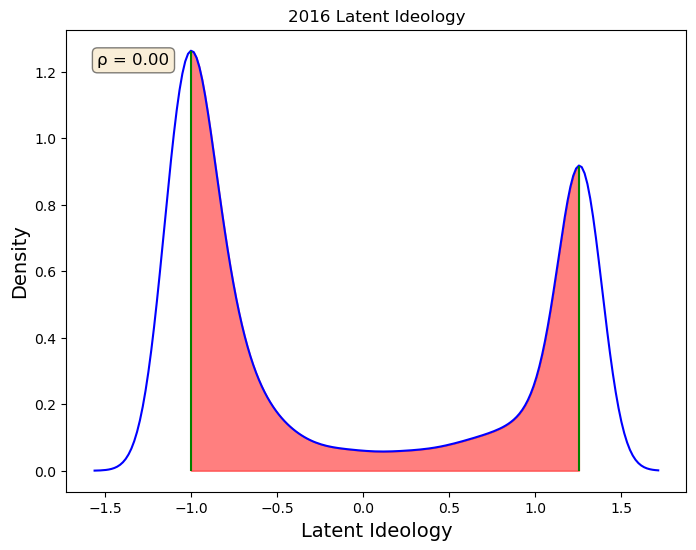

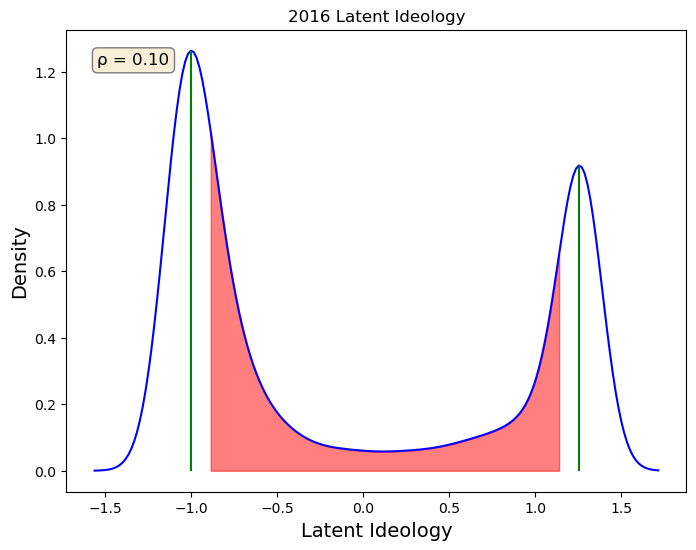

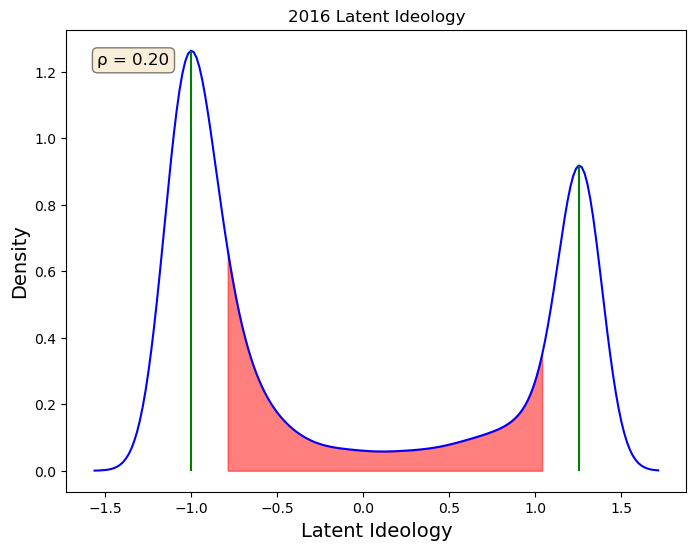

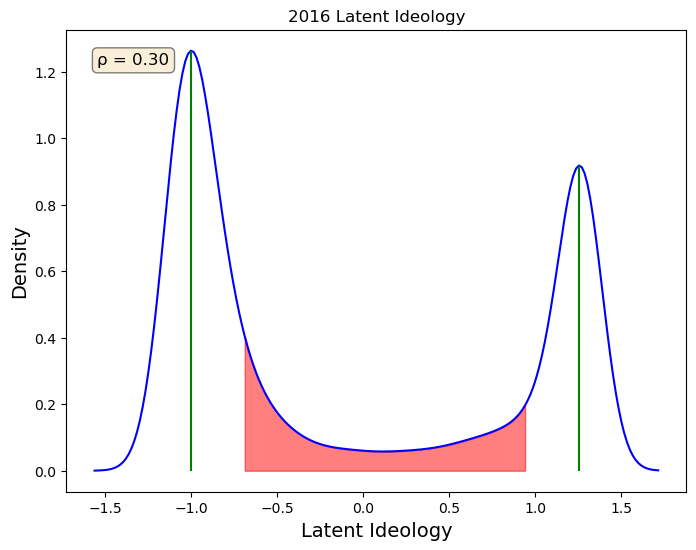

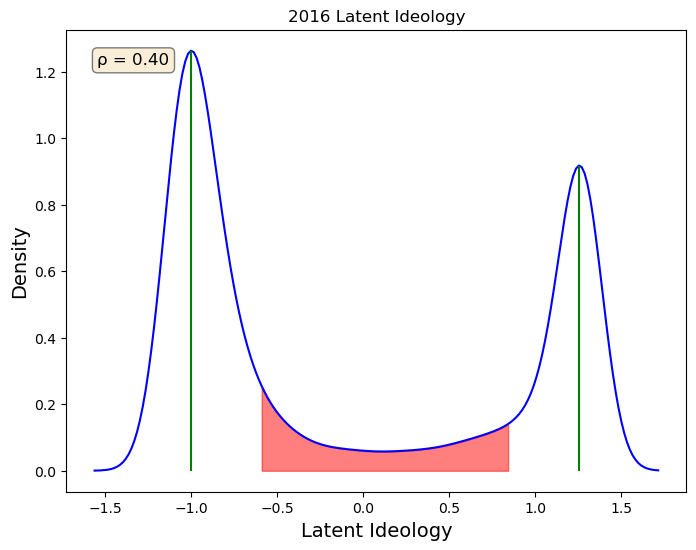

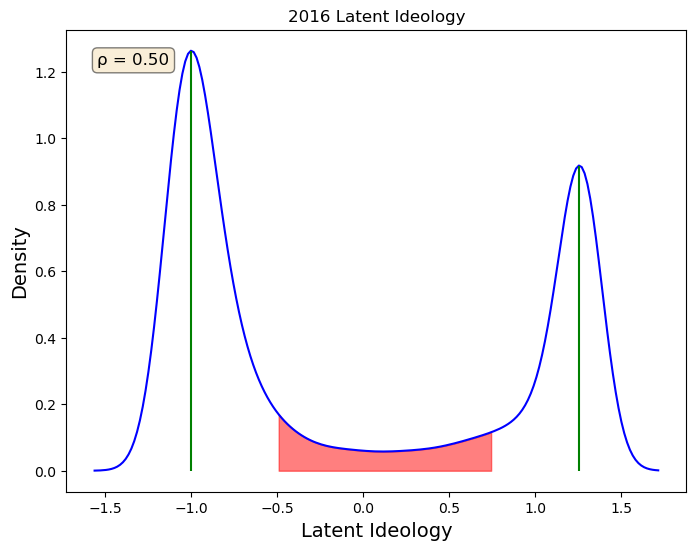

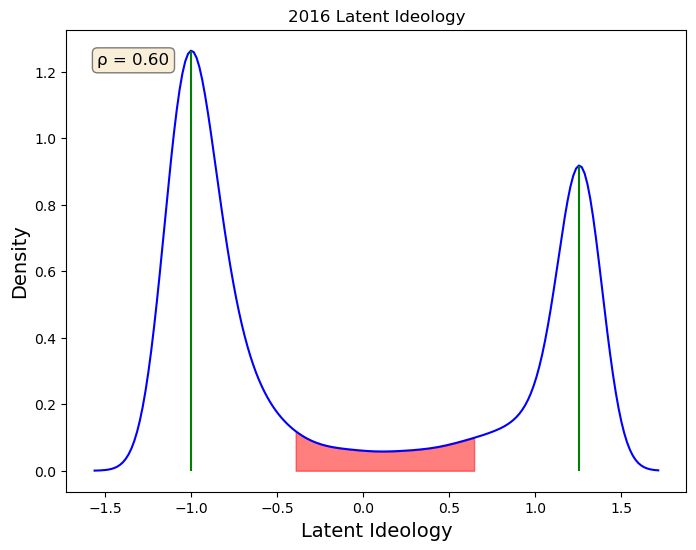

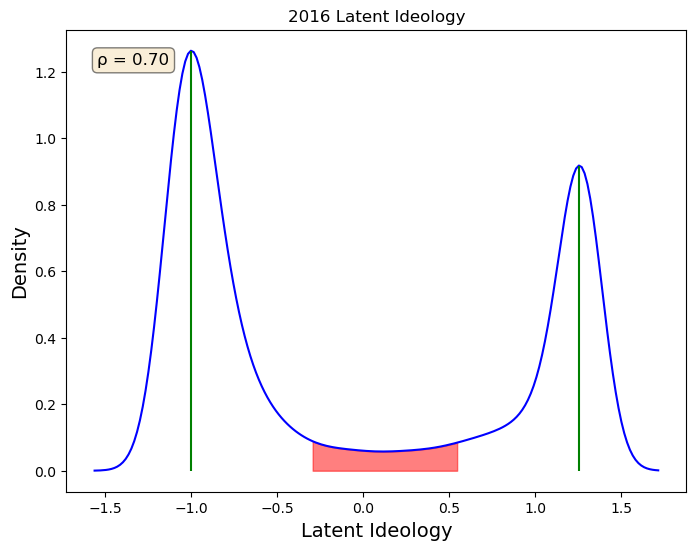

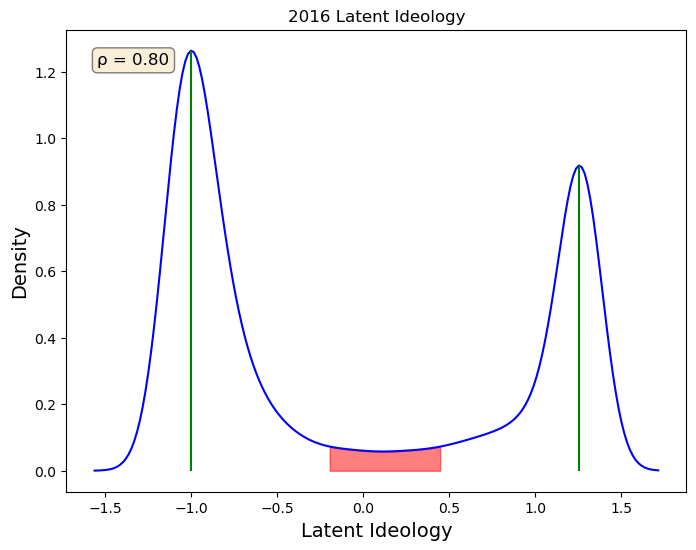

In [15]:
#Latent ideology boundaries 

for i in range(len(dataframes)):
        
    # Assuming df is your DataFrame and distance_from_the_peak is defined
    fig, ax = plt.subplots(figsize=(8, 6))
    x_vals, kde_vals, x1, x2,y1,y2 = kde_plots[i]
    ax.plot(x_vals, kde_vals, color='blue')
    
    ax.vlines(x=peaks_2016[0],ymin=0,ymax=y1,colors='green')
    ax.vlines(x=peaks_2016[1],ymin=0,ymax=y2,colors='green')
    
    if x1 is not None and x2 is not None:
        ax.fill_between(x_vals, kde_vals, where=((x_vals >= x1) & (x_vals <= x2)), color='red', alpha=0.5)
    
    ax.set_title('2016 Latent Ideology')
    ax.set_ylabel('Density', fontsize=14)
    ax.set_xlabel('Latent Ideology', fontsize=14)
    
    textstr = '\n'.join((
    f'ρ = {distance_from_the_peak[i]:.2f}',))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    
    # Save the plot as a PDF
    #plt.savefig(f'nonp_regression_LI_{i}_neg.pdf')
    
    # Show plot
    plt.show()

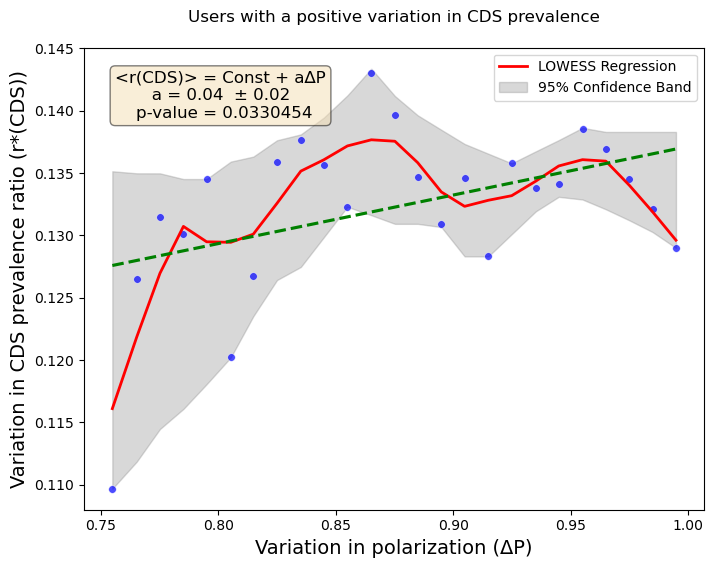

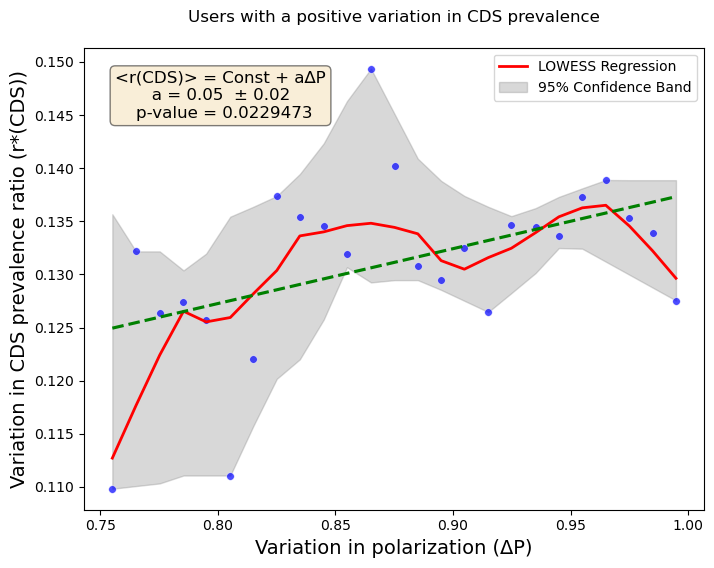

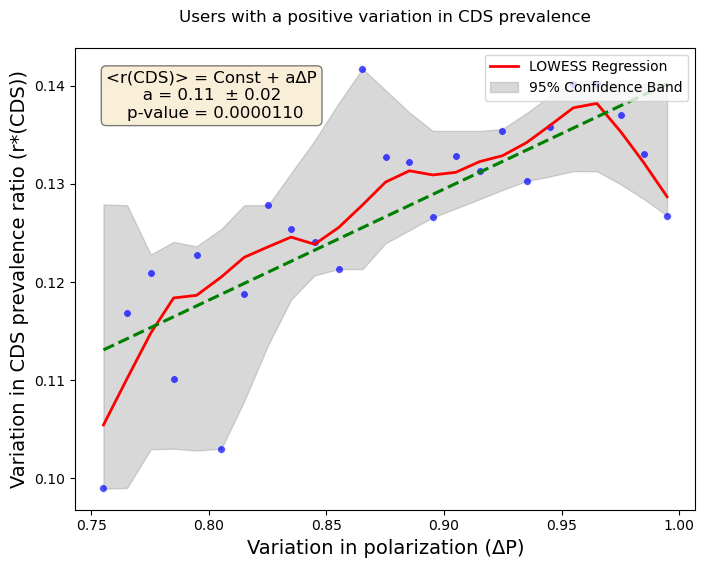

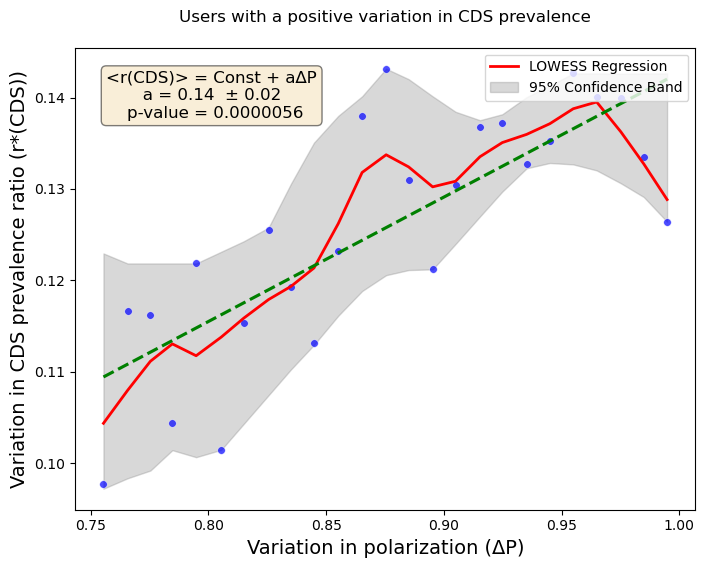

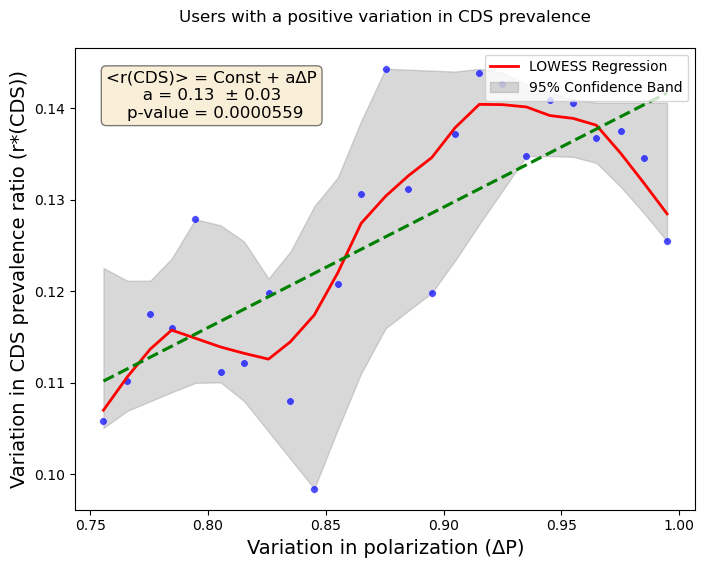

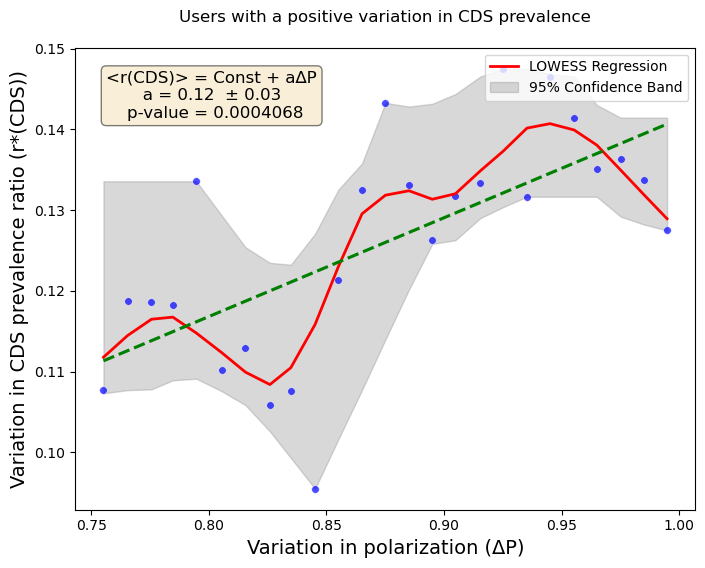

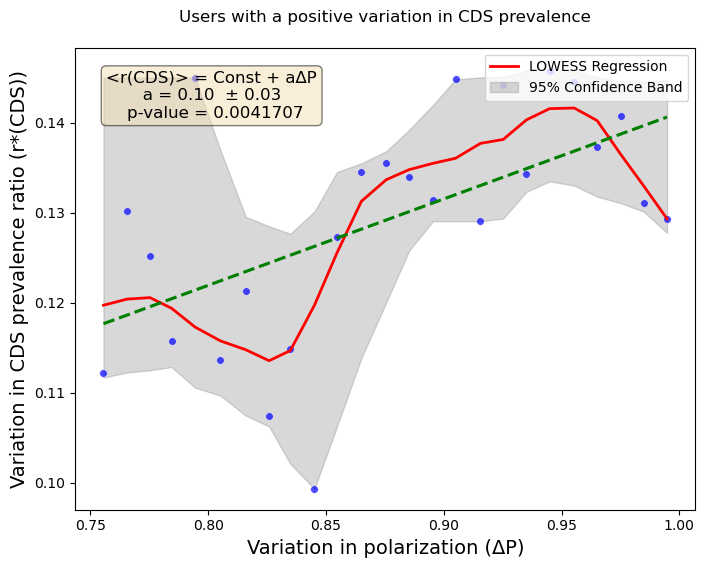

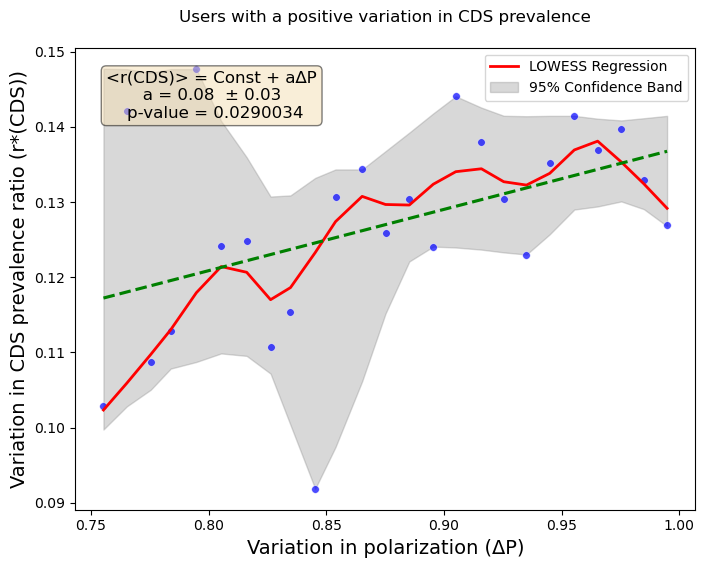

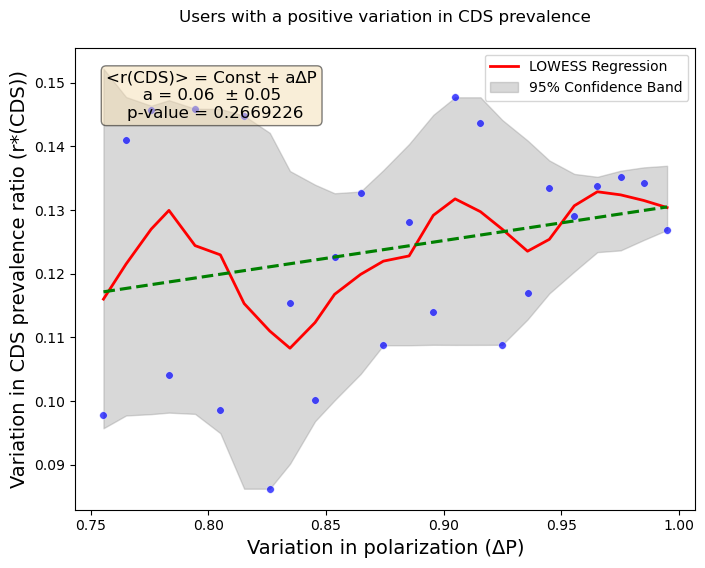

In [16]:
# Plots r*(CDS) abore zero

for i in range(len(dataframes)):
    
    # Assuming df is your DataFrame and distance_from_the_peak is defined
    fig, ax = plt.subplots(figsize=(8, 6))
    x,y_pred,lower_bound,upper_bound,y_pred_ols,slope,slop_p = Boostrap_a[i]
    
    # Plot the LOWESS regression line
    ax.plot(x, y_pred,'-',color="red",label="LOWESS Regression",linewidth=2)
    
    # Plot the confidence band
    ax.fill_between(x, lower_bound, upper_bound, color="gray", alpha=0.3, label="95% Confidence Band")

    sns.scatterplot(x='metric', y='delta_y', data=dataframes[i], s=30, color='blue', alpha=0.7, zorder=1, ax=ax)
    
    # Plot the OLS regression line
    #ax.plot(x, y_pred_ols, '-.',color="green", label="OLS Regression",linewidth=3)
    sns.regplot(x='metric', y='delta_y', data=dataframes[i], ci=None,  scatter=False, line_kws={"color": "green","linestyle": "--"}, ax=ax)
    
    ax.set_xlabel('Variation in polarization (ΔP)', fontsize=14)
    ax.set_ylabel('Variation in CDS prevalence ratio (r*(CDS))', fontsize=14)
    
    ax.set_title(f'Users with a positive variation in CDS prevalence\n')
        #ax_inset_hist.set_ylim(-0.3, 0.05)
    
    textstr = '\n'.join((
    f'<r(CDS)> = Const + a∆P',
    f'       a = {coefficients_[i]["metric"]:.2f}  ± {errors[i]["metric"]:.2f}  ',
    f'    p-value = {p_values_[i]["metric"]:.7f}',

    ))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Add legend and place it in the top right corner
    ax.legend(loc='upper right')
    
    # Save the plot as a PDF
    #plt.savefig(f'nonp_regression_{i}_neg.pdf')
    
    # Show plot
    plt.show()


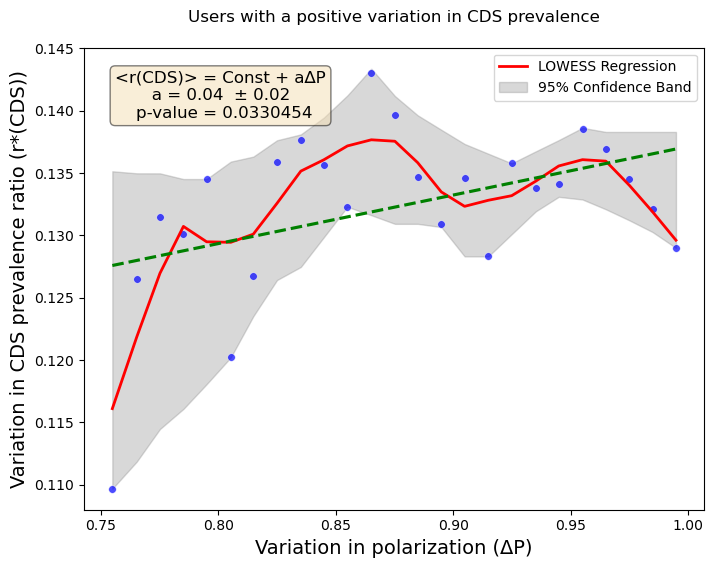

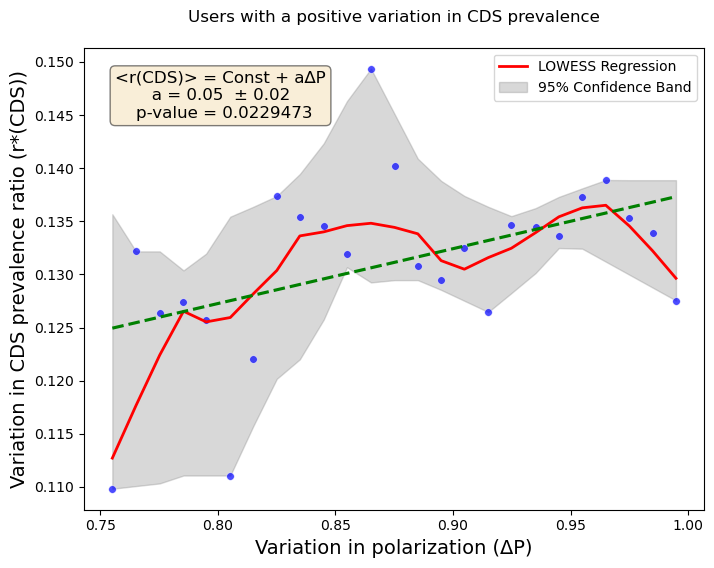

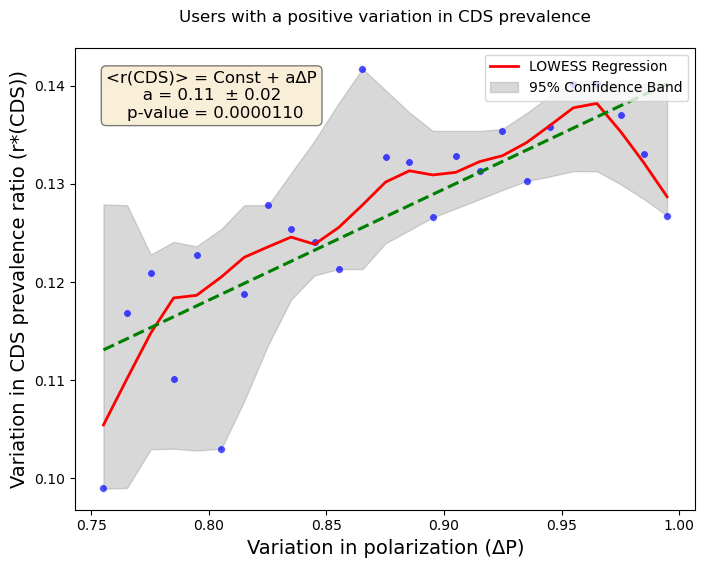

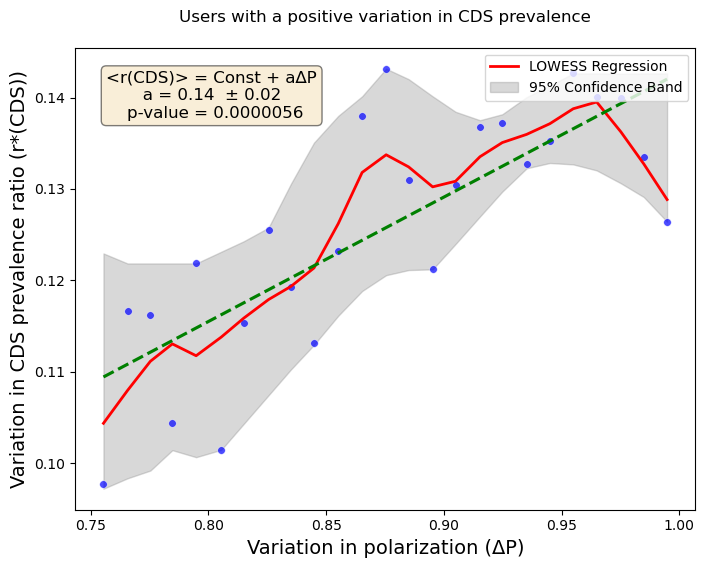

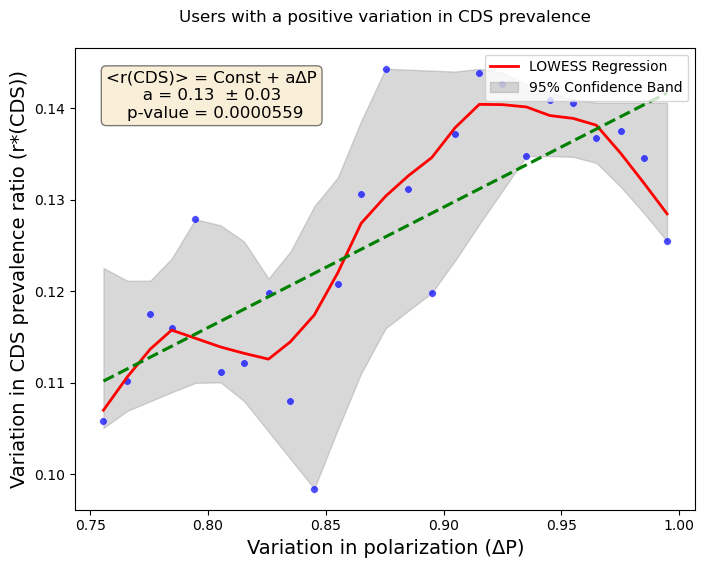

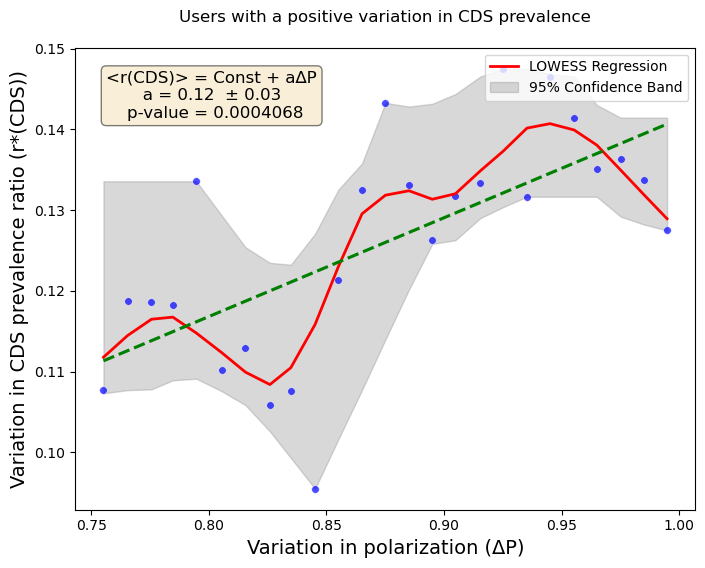

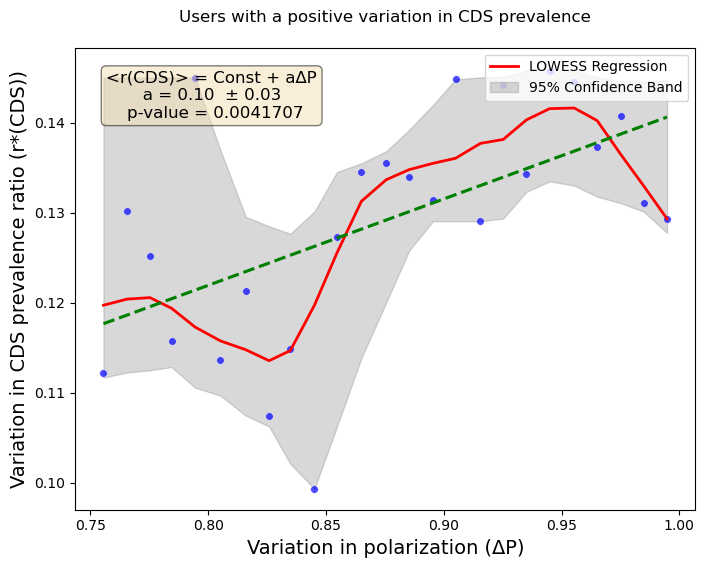

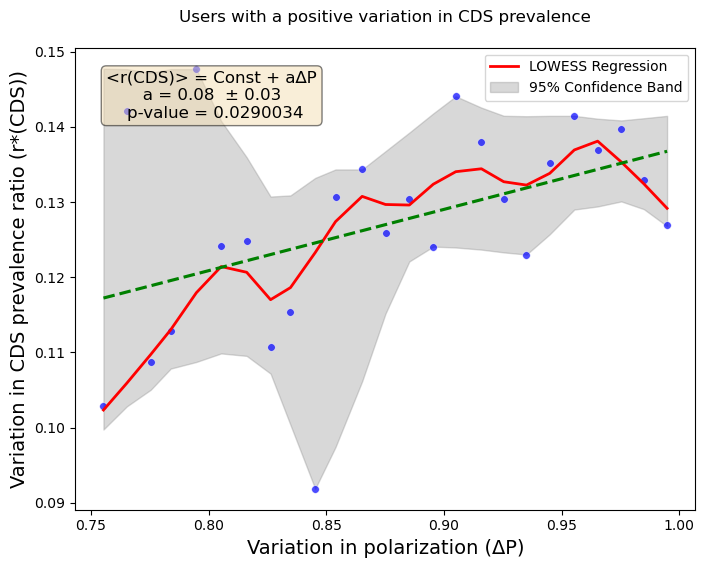

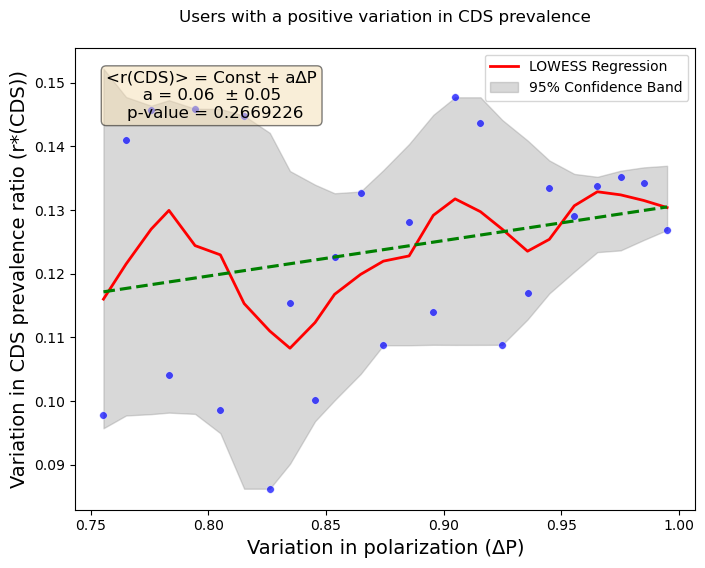

In [17]:
# Plots r*(CDS) below zero

for i in range(len(dataframes)):
    
    # Assuming df is your DataFrame and distance_from_the_peak is defined
    fig, ax = plt.subplots(figsize=(8, 6))
    x,y_pred,lower_bound,upper_bound,y_pred_ols,slope,slop_p = Boostrap_a[i]
    
    # Plot the LOWESS regression line
    ax.plot(x, y_pred,'-',color="red",label="LOWESS Regression",linewidth=2)
    
    # Plot the confidence band
    ax.fill_between(x, lower_bound, upper_bound, color="gray", alpha=0.3, label="95% Confidence Band")

    sns.scatterplot(x='metric', y='delta_y', data=dataframes[i], s=30, color='blue', alpha=0.7, zorder=1, ax=ax)
    
    # Plot the OLS regression line
    sns.regplot(x='metric', y='delta_y', data=dataframes[i], ci=None,  scatter=False, line_kws={"color": "green","linestyle": "--"}, ax=ax)
    
    ax.set_xlabel('Variation in polarization (ΔP)', fontsize=14)
    ax.set_ylabel('Variation in CDS prevalence ratio (r*(CDS))', fontsize=14)
    
    ax.set_title(f'Users with a positive variation in CDS prevalence\n')
        #ax_inset_hist.set_ylim(-0.3, 0.05)
    
    textstr = '\n'.join((
    f'<r(CDS)> = Const + a∆P',
    f'       a = {coefficients_[i]["metric"]:.2f}  ± {errors[i]["metric"]:.2f}  ',
    f'    p-value = {p_values_[i]["metric"]:.7f}',

    ))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Add legend and place it in the top right corner
    ax.legend(loc='upper right')
    
    # Save the plot as a PDF
    #plt.savefig(f'nonp_regression_{i}_neg.pdf')
    
    # Show plot
    plt.show()